In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
import io
import chess
import chess.pgn
import chess.svg
import numpy as np
import os
from tqdm import tqdm
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix, vstack
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from joblib import dump, load
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from ipywidgets import HBox, widgets, Layout, Button
from IPython.display import display, HTML
import base64
import re

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

In [2]:
def games_from_drive():
    max_games = 500000 
    asset_dir = 'asset'
    file_name = '2023_tc_500000_games.pgn'

    gauth = GoogleAuth()
    gauth.DEFAULT_SETTINGS['client_config_file'] = 'client_secret_1057507276332-5mk9ac9q22rsmtm1idlqvpraq08ar8p5.apps.googleusercontent.com.json'
    gauth.LoadCredentialsFile("mycreds.txt")
    if gauth.credentials is None:
        gauth.LocalWebserverAuth()
    elif gauth.access_token_expired:
        gauth.Refresh()
    else:
        gauth.Authorize()

    gauth.SaveCredentialsFile("mycreds.txt")
    drive = GoogleDrive(gauth)

    def load_pgns_from_text(pgns_text, num_games=None, start_index=0, encoding="utf-8"):
        games = []
        file_io = io.StringIO(pgns_text)
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file_io)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file_io)
            if game is None:
                break
            games.append(game)
        return games

    def find_folder_id(folder_name):
        file_list = drive.ListFile({'q': f"title='{folder_name}' and mimeType='application/vnd.google-apps.folder' and trashed=false"}).GetList()
        for file in file_list:
            if file['title'] == folder_name:
                return file['id']
        return None

    def read_pgn_file_from_drive(file_title, parent_id):
        query = f"'{parent_id}' in parents and trashed=false and title='{file_title}'"
        file_list = drive.ListFile({'q': query}).GetList()
        if not file_list:
            print(f"No file found with title: {file_title}")
            return None
        file = file_list[0]
        urls = file.GetContentString(encoding='UTF-8')
        return urls

    chess_games_loaded = False
    print("loading pgn...")
    asset_folder_id = find_folder_id(asset_dir)

    if asset_folder_id is None:
        print("Asset folder not found.")
    else:
        pgns_text = read_pgn_file_from_drive(file_name, asset_folder_id)
        games = load_pgns_from_text(pgns_text, num_games=max_games)
        if games is not None:
            print("pgn file loaded successfully.")
    return games

In [3]:
def load_pgns(file_path, num_games=None, start_index=0, encoding="utf-8"):
    games = []
    with open(file_path, "r", encoding=encoding) as file:
        for _ in tqdm(range(start_index), desc='Skipping games', unit='game', leave=False):
            game = chess.pgn.read_game(file)
            if game is None:
                break
        for _ in tqdm(range(num_games), desc='Loading games', unit='game', leave=True) if num_games else iter(int, 1):
            game = chess.pgn.read_game(file)
            if game is None:
                break
            games.append(game)
    return games

In [4]:
assets_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
single_path = os.path.join(assets_path, 'kgames_sample.pgn')
#single_path = os.path.join(assets_path, '2023_tc_50000_games.pgn')

games = load_pgns(single_path, 1000)
#games = games_from_drive()

Loading games: 100%|██████████| 1000/1000 [00:02<00:00, 337.27game/s]


In [5]:
def povscore_to_int(eval, turn):
    eval = str(eval)
    if eval[0] != '#':
        evaluation = float(eval)
    else:
        if eval[1] != '-':
            evaluation = 10
        else:
            evaluation = -10
    return evaluation*(-1)**(not turn)

def get_eval_from_result(result):
    if result == '1-0':
        return 10
    elif result == '0-1':
        return -10
    else:
        return 0

In [6]:
def game_to_csr_matrix(game):
    result = game.headers['Result']
    board = game.board()
    fen_array_list = []
    evals_list = []
    turn = chess.WHITE

    for node in game.mainline():
        move = node.move
        board.push(move)
        turn = not turn
        fen_array = board_to_array(board)
        orient_array = orient_board(fen_array, turn)
        fen_array_list.append(orient_array)

        comment = node.comment
        eval_match = re.search(r"\[%eval (.*?)\]", comment)
        eval_tag = eval_match.group(1) if eval_match else get_eval_from_result(result)
        evals_list.append(povscore_to_int(eval_tag,turn))

    game_csr_matrix = csr_matrix(np.array(fen_array_list))
    evals_list = np.clip(evals_list, -10, 10)

    return game_csr_matrix, evals_list

def board_to_array(board):
    standard_counts = [8,2,2,2,1]
    board_array = []
    materials = []
    for color in chess.COLORS:
        for piece in chess.PIECE_TYPES:
            vector, count = bitboard_of_piece(board, piece, color)
            board_array.extend(vector)
            try:
                materials.append(count/standard_counts[piece-1])
            except:
                pass

    castles = get_castle_info(board)
    peasants = get_en_passant_array(board)
    board_array.extend(castles)
    board_array.extend(peasants)
    board_array.extend(materials)

    turn = board.turn
    halfmove_clock = board.halfmove_clock * 0.01
    board_array.append(turn)  # 1 for white's turn, 0 for black's turn
    board_array.append(halfmove_clock)
    
    return np.array(board_array)

def bitboard_of_piece(board, piece_type, color):
    bit_array = np.zeros(64, dtype=int)
    squares = list(board.pieces(piece_type, color))
    piece_count = len(squares)
    bit_array[squares] = 1
    return bit_array, piece_count

def get_en_passant_array(board):
    en_passant_array = np.zeros(64, dtype=int)
    if board.ep_square is not None:
        en_passant_array[board.ep_square] = 1
    relevant_squares = np.concatenate((en_passant_array[16:24], en_passant_array[40:48]))
    return relevant_squares

def get_castle_info(board):
    white_kingside = board.has_castling_rights(chess.WHITE) and board.has_kingside_castling_rights(chess.WHITE)
    white_queenside = board.has_castling_rights(chess.WHITE) and board.has_queenside_castling_rights(chess.WHITE)
    black_kingside = board.has_castling_rights(chess.BLACK) and board.has_kingside_castling_rights(chess.BLACK)
    black_queenside = board.has_castling_rights(chess.BLACK) and board.has_queenside_castling_rights(chess.BLACK)
    return [white_kingside, white_queenside, black_kingside, black_queenside]

def orient_board(board_vec, turn):
    if turn == chess.WHITE:
        perspective_vec = board_vec[:768]
        self_castles = board_vec[768:770]
        opponenet_castles = board_vec[770:772]
        possible_peasant = board_vec[772:780]
        self_piececount = board_vec[788:793]
        opponent_piececount = board_vec[793:798]
        fifty_and_turn = board_vec[-2:][::-1]
    else:
        flipped_vec = np.array([mat[::-1] for mat in board_vec[:768].reshape(12,8,8)]).reshape(-1)
        perspective_vec = np.concatenate([flipped_vec[384:],flipped_vec[:384]])
        self_castles = board_vec[770:772]
        opponenet_castles = board_vec[768:770]
        possible_peasant = board_vec[780:788]
        self_piececount = board_vec[793:798]
        opponent_piececount = board_vec[788:793]
        fifty_and_turn = board_vec[-2:][::-1]
            
    player_vec = np.concatenate([perspective_vec, self_castles, opponenet_castles, possible_peasant, self_piececount, opponent_piececount, fifty_and_turn])
    return player_vec

In [7]:
def reverse_orient_board(player_vec):
    turn = int(player_vec[-1])
    
    if turn == chess.WHITE:
        perspective_vec = player_vec[:768]
        white_castles = player_vec[768:770]
        black_castles = player_vec[770:772]
        possible_peasant = np.concatenate([player_vec[772:780],[0]*8])
        white_piececount = player_vec[780:785]
        black_piececount = player_vec[785:790]
        fifty_and_turn = player_vec[-2:][::-1]
        
    else:
        unflipped_vec = np.array([mat[::-1] for mat in player_vec[:768].reshape(12,8,8)]).reshape(-1)
        perspective_vec = np.concatenate([unflipped_vec[384:],unflipped_vec[:384]])
        black_castles = player_vec[768:770]
        white_castles = player_vec[770:772]
        possible_peasant = np.concatenate([[0]*8, player_vec[772:780]])
        black_piececount = player_vec[780:785]
        white_piececount = player_vec[785:790]
        fifty_and_turn = player_vec[-2:][::-1]

    board_vec = np.concatenate([perspective_vec, white_castles, black_castles, possible_peasant, white_piececount, black_piececount, fifty_and_turn])
    return board_vec

In [8]:
def vector_to_fen(vector):
    piece_symbols = "PNBRQKpnbrqk"
    board = [""] * 64

    for square in range(64):
        for piece_index in range(12):
            if vector[piece_index * 64 + square] == 1:
                board[square] = piece_symbols[piece_index]
                break

    fen_parts = []
    for rank in range(8, 0, -1):
        empty_count = 0
        rank_str = ""
        for file in range(8):
            piece = board[(rank-1)*8 + file]
            if piece == "":
                empty_count += 1
            else:
                if empty_count > 0:
                    rank_str += str(empty_count)
                    empty_count = 0
                rank_str += piece
        if empty_count > 0:
            rank_str += str(empty_count)
        fen_parts.append(rank_str)

    piece_placement = "/".join(fen_parts)
    
    active_color = "w" if vector[-2] == 1 else "b"
    
    castling_rights = ''.join(['K' if vector[768] == 1 else '',
                               'Q' if vector[769] == 1 else '',
                               'k' if vector[770] == 1 else '',
                               'q' if vector[771] == 1 else '',])
    if castling_rights == "":
        castling_rights = "-"

    en_passant_vector = vector[772:788]
    en_passant_target = "-"
    for i, val in enumerate(en_passant_vector):
        if val == 1:
            en_passant_target = chess.SQUARE_NAMES[16 + i] if i < 8 else chess.SQUARE_NAMES[40 + (i - 8)]
            break
    
    halfmove_clock = int(vector[-1])
    
    fullmove_number = "1"
    
    fen = f"{piece_placement} {active_color} {castling_rights} {en_passant_target} {halfmove_clock} {fullmove_number}"
    
    return fen

In [9]:
try:
    if len(games) < 10000:
        raise ValueError
    game_csr_matrices = load('orient_csr.joblib')
    evaluations = load('orient_rating.joblib')
except:
    print('Converting Games...')
    game_csr_objects = [game_to_csr_matrix(game) for game in games]
    game_csr_matrices = [tup[0] for tup in game_csr_objects]
    evaluations = [tup[1] for tup in game_csr_objects]
    
    #dump(game_csr_matrices, 'orient_csr.joblib')
    #dump(evaluations, 'orient_rating.joblib')

Converting Games...


In [10]:
game_lengths = [mat.shape[0] for mat in game_csr_matrices]
all_board_csr_matrix = vstack(game_csr_matrices)
all_evaluations = np.concatenate([*evaluations])

cumulative_lengths = np.cumsum(game_lengths)

In [11]:
X_array = all_board_csr_matrix[:,:768].toarray()
X_array = X_array.reshape(len(X_array),12,8,8)
X = torch.tensor(X_array, dtype=torch.float32)
y = torch.tensor(all_evaluations, dtype=torch.float32)

dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class ChessCNN(nn.Module):
    def __init__(self):
        super(ChessCNN, self).__init__()
        self.conv1 = nn.Conv2d(12, 64, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.res_blocks = nn.Sequential(
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64),
            ResidualBlock(64)
        )
        
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x, return_intermediate=False):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.res_blocks(x)
        if return_intermediate:
            return x
        x = F.relu(self.bn2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ChessCNN()

In [13]:
def test_model():
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            total_loss += loss.item()
    print(f'Validation Loss: {total_loss/len(val_loader)}')

def train_model(epochs=16):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')
        test_model()

In [14]:
model_save_path = 'chess_cnn_model.pth'

model = ChessCNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

try:
    checkpoint = torch.load(model_save_path, map_location=device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.load_state_dict(checkpoint['model_state_dict'])
except:
    train_model()
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, model_save_path)

In [15]:
def CNN_cosine_similarity(model, query_tensor, position_tensors):
    model.eval()
    with torch.no_grad():
        query_tensor = query_tensor.unsqueeze(0).to(device)
        position_tensors = position_tensors.to(device)
        query_tensor = query_tensor.to(next(model.parameters()).device)

        query_representation = model(query_tensor, return_intermediate=True).flatten(start_dim=1)
        position_representations = model(position_tensors, return_intermediate=True).flatten(start_dim=1)
        similarity = F.cosine_similarity(query_representation, position_representations, dim=1)
    return similarity.cpu().numpy()

In [16]:
query_fen = 'r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 2 12' #carlsbad
#query_fen = 'rnb2b1r/2Nnkppp/p2pp3/8/PPBN1P2/2p3Pq/4Q2P/R3K1R1 w Q - 1 17' #najdorf
#query_fen = '6k1/5p2/1r2p1p1/3p1n2/3P3p/1P1R3P/4NPP1/6K1 b - - 2 36' #rkendgame
query_array = board_to_array(chess.Board(fen=query_fen))
query_array = orient_board(query_array, query_fen.split()[1]=='w')[:768]

shape = (12,8,8)
query_tensor = torch.tensor(query_array, dtype=torch.float32).view(*shape)
position_tensors = torch.tensor(X_array, dtype=torch.float32).view(-1, *shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

similarity = CNN_cosine_similarity(model, query_tensor, position_tensors)

r1b1r1k1/pp1nqppp/2p5/3p4/3Pn3/2NBPN2/PPQ2PPP/R4RK1 w - - 2 12


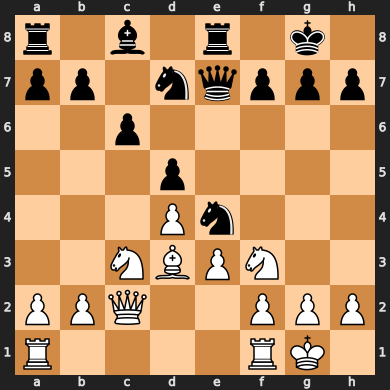

----------------------------------------------------------------
r4rk1/1pqn1ppp/p2bp3/3p4/3P4/2P3P1/PP1NQPPN/R3R1K1 b - - 0 1


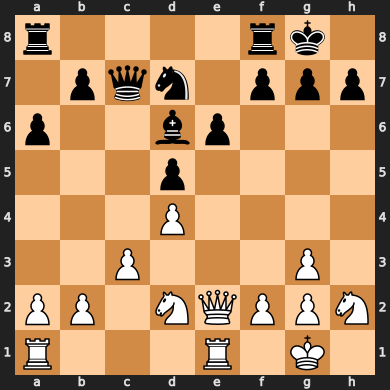

r1b2rk1/pp1nq1p1/2p1p2p/3p1p2/2PPn3/2N1PN2/PPQ1BPPP/R4RK1 w - - 0 1


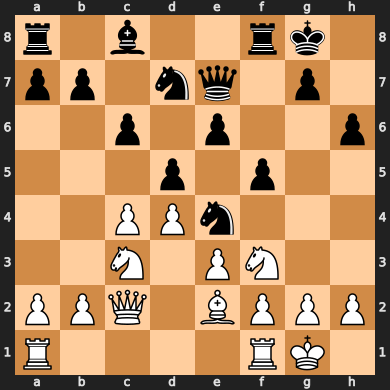

r4rk1/2qn1ppp/p2bp3/1p1p4/3P4/2P2NP1/PP1NQPP1/R3R1K1 b - - 0 1


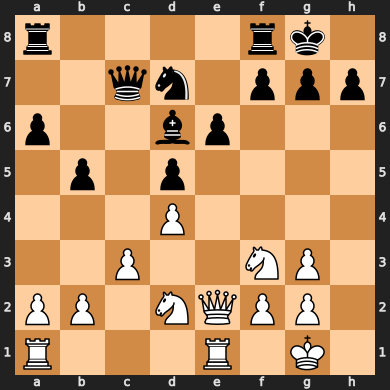

r3r1k1/1ppbqppp/p1n5/3p4/3P4/3BPN2/PP3PPP/R2Q1RK1 w - - 0 1


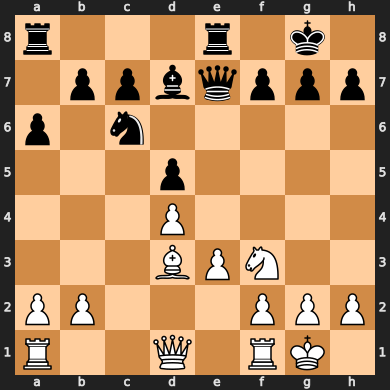

r4rk1/ppq2pp1/2nbpn1p/3pN3/3P4/2P3B1/PP1NQPPP/R3K2R b KQ - 0 1


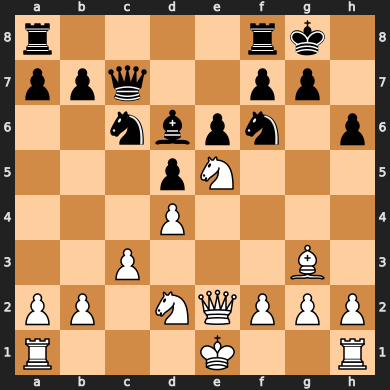

r4rk1/2qn1ppp/p2bp3/3p4/3P4/2P2NP1/P2NQPP1/2R1R1K1 b - - 0 1


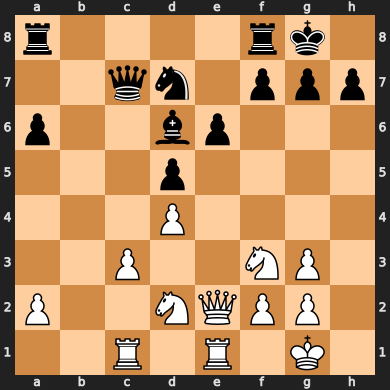

r1b2rk1/pp1nqpp1/2p1p2p/3p4/2PPn3/2N1PN2/PP2BPPP/R2Q1RK1 w - - 0 1


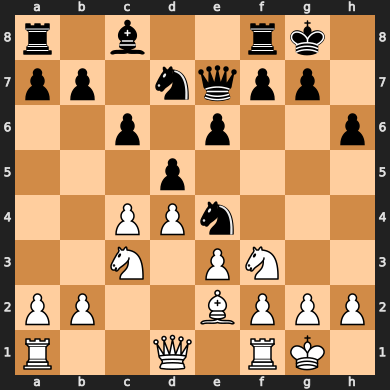

r4rk1/2qn1ppp/p2bp3/3p4/1p1P4/2P2NP1/PP1NQPP1/2R1R1K1 b - - 0 1


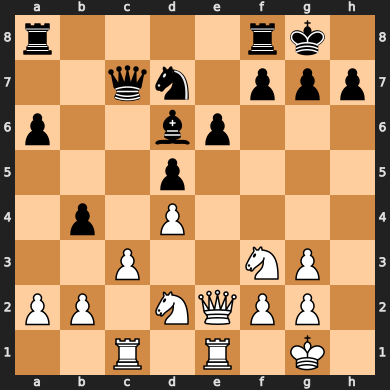

r1b2rk1/pp1nq2p/2p1p3/2Pp1pp1/1P1Pn3/P1N2NP1/2Q1PPBP/R4RK1 w - - 0 1


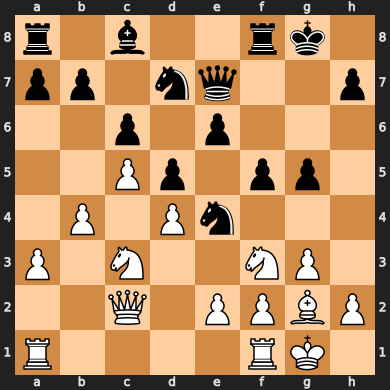

r1b2rk1/pp1nq1pp/2pbp3/3p1p2/2PPnB2/P1N2NP1/1PQ1PPBP/R4RK1 w - - 0 1


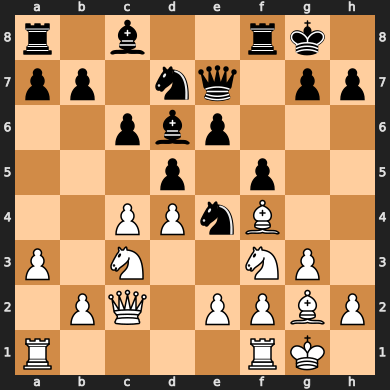

r1b2rk1/pp1nq2p/2p5/2Ppppp1/PP1Pn3/2N2NP1/2Q1PPBP/R4RK1 w - - 0 1


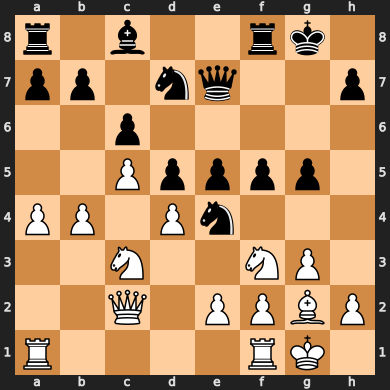

r1b2rk1/pp2q1p1/2p1pn1p/3p1p2/2PPn3/2N1PN2/PPQ1BPPP/3R1RK1 w - - 0 1


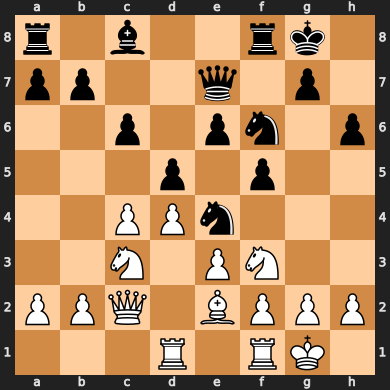

r3r1k1/1p1bqppp/p1p5/3p4/1n1P4/4PN2/PP3PPP/1BRQ1RK1 w - - 0 1


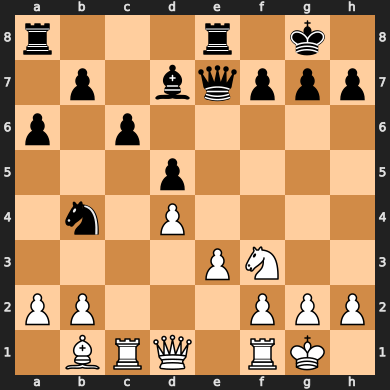

r4rk1/ppqn1ppp/3bp3/3p4/3P4/2P3P1/PP1NQPPN/R4RK1 b - - 0 1


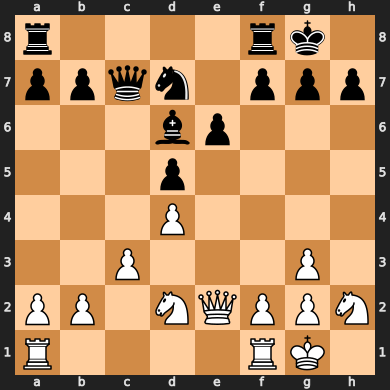

r1b2rk1/ppq1np1p/2p1p1p1/4b3/2B1P3/2P3P1/PP2QP1P/R1B1RNK1 b - - 0 1


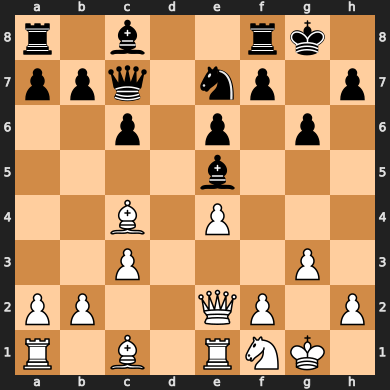

r4rk1/1ppbqppp/p1n5/1B1p4/3P4/4PN2/PP3PPP/R2Q1RK1 w - - 0 1


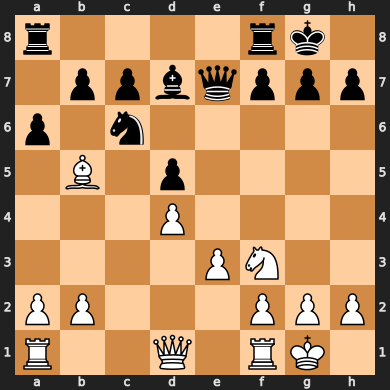

r2q1rk1/pp2bppp/4bn2/2p1N3/8/2N5/PP2QPPP/R1B1R1K1 b - - 0 1


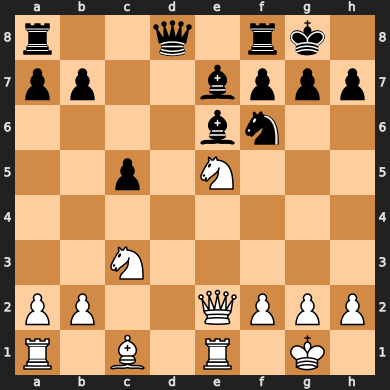

r1b2rk1/pp1nq2p/2pnp3/3p1pp1/1PPP4/P1N2NP1/2Q1PPBP/R4RK1 w - - 0 1


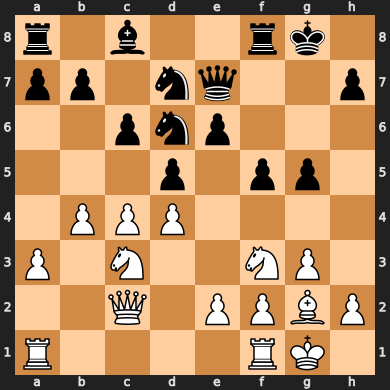

r3r1k1/1ppbqppp/p7/3p4/1n1P4/3BPN2/PP3PPP/2RQ1RK1 w - - 0 1


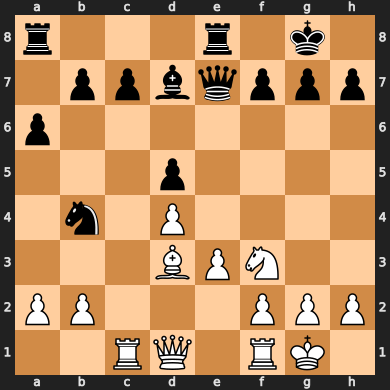

r1b2rk1/pp1nq2p/2pbp3/3p1pp1/1PPPnB2/P1N2NP1/2Q1PPBP/R4RK1 w - - 0 1


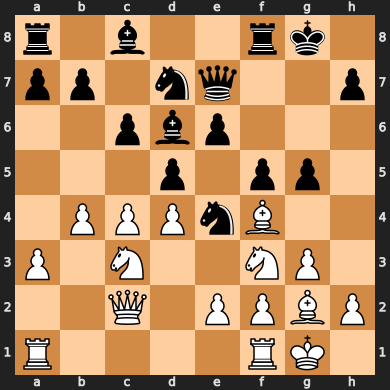

r1b1r1k1/pp1nqppp/2pb1n2/6B1/2BR4/2N1PN2/PP2QPPP/5RK1 w - - 0 1


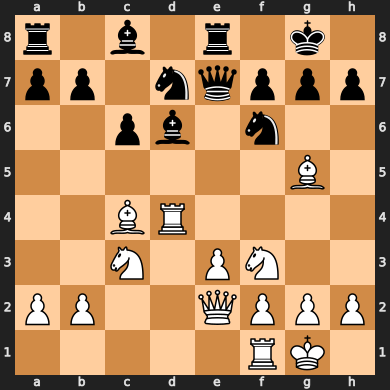

rn3rk1/ppq2ppp/2pbbn2/3p4/3P4/2PB1N2/PP3PPP/R1BQRNK1 b - - 0 1


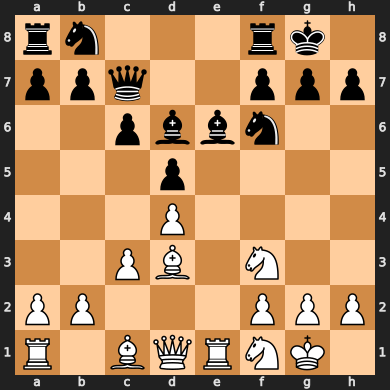

r2q1rk1/pp1nbppp/4pn2/3pN3/3P4/1P6/PBPNQPPP/R4RK1 b - - 0 1


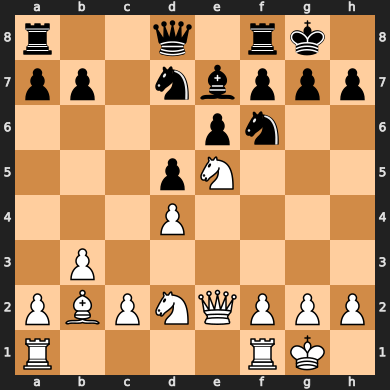

r1b2rk1/p1q1np1p/2p1p1p1/1p2b3/4P3/1BP3P1/PP2QP1P/R1B1RNK1 b - - 0 1


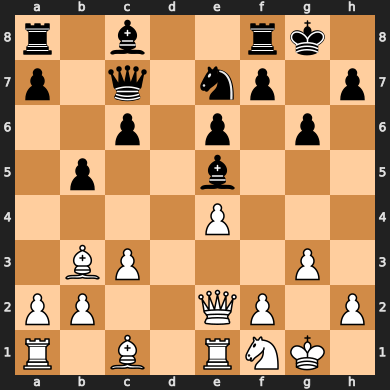

rn1q1rk1/pp2bppp/2p1pn2/3pN3/3P4/1P2P3/P1PNQPPP/R1B2RK1 b - - 0 1


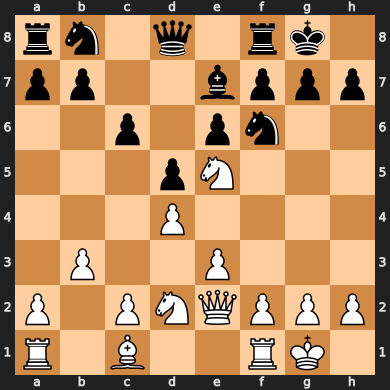

In [17]:
k=25
top_k_indices = np.argsort(similarity)[-k:][::-1]
similarity[top_k_indices]

print(query_fen)
display(chess.Board(fen=query_fen))
print('-'*64)

for ind in top_k_indices:
    fen_array = all_board_csr_matrix[ind]
    vector = reverse_orient_board(fen_array.toarray()[0])
    fen_string = vector_to_fen(vector)
    print(fen_string)
    display(chess.Board(fen=fen_string))

In [19]:
query_array = board_to_array(chess.Board(fen=query_fen))
query_array = orient_board(query_array, query_fen.split()[1]=='w')[:768]
query_array = [1]*768

shape = (12,8,8)
query_tensor = torch.tensor(query_array, dtype=torch.float32).view(*shape)
position_tensors = torch.tensor(X_array, dtype=torch.float32).view(-1, *shape)

model.eval()
with torch.no_grad():
    query_tensor = query_tensor.unsqueeze(0).to(device)
    position_tensors = position_tensors.to(device)
    query_tensor = query_tensor.to(next(model.parameters()).device)

    query_representation = model(query_tensor, return_intermediate=True).flatten(start_dim=1)
    position_representations = model(position_tensors, return_intermediate=True).flatten(start_dim=1)
    similarity = F.cosine_similarity(query_representation, position_representations, dim=1)
[similarity[k].item() for k in top_k_indices]

[0.2708181142807007,
 0.28357988595962524,
 0.27716338634490967,
 0.2660163640975952,
 0.2707326412200928,
 0.26820144057273865,
 0.3095287084579468,
 0.26709824800491333,
 0.28874924778938293,
 0.32987678050994873,
 0.27247539162635803,
 0.29925402998924255,
 0.2579902410507202,
 0.27007347345352173,
 0.2878469228744507,
 0.2696145474910736,
 0.2713169753551483,
 0.3036233186721802,
 0.2609971761703491,
 0.32120996713638306,
 0.2939547300338745,
 0.3411741256713867,
 0.28827738761901855,
 0.28001153469085693,
 0.3051454722881317]